Setup

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential

2023-10-02 15:02:30.844925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 15:02:31.548891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Load data

In [2]:
batch_size = 32
img_height = 224
img_width = 224

In [3]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  'hirise-oversample',
  batch_size = batch_size,
  image_size = (img_height, img_width),
  shuffle = True,
  seed = 321,
  validation_split = 0.2,
  subset = "training"
)

Found 34293 files belonging to 7 classes.
Using 27435 files for training.


2023-10-02 15:02:33.755120: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  'hirise-oversample',
  batch_size = batch_size,
  image_size = (img_height, img_width),
  shuffle = False,
  seed = 321,
  validation_split = 0.2,
  subset = "validation",
)

Found 34293 files belonging to 7 classes.
Using 6858 files for validation.


In [5]:
#list of class names:
class_lookup = ['other', 'crater', 'dark dune', 'slope streak', 'bright dune', 'impact ejecta', 'swiss cheese', 'spider']
for i in range(1, len(class_lookup)):
    print(str(i) + ' ' + class_lookup[i])

1 crater
2 dark dune
3 slope streak
4 bright dune
5 impact ejecta
6 swiss cheese
7 spider


In [6]:
class_names = train_ds.class_names
print(class_names)

['bright dune', 'crater', 'dark dune', 'impact ejecta', 'slope streak', 'spider', 'swiss cheese']


ValueError: invalid literal for int() with base 10: 'dark dune'

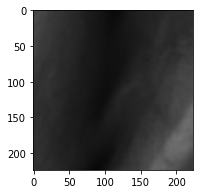

In [7]:
#show examples of different classes

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label = class_names[labels[i]]
    plt.title(label + ": " + class_lookup[int(label)])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.layers import *

class ResNetBlock(Layer):

  def __init__(self, out_channels, first_stride = 1):
    super().__init__()

    first_padding = 'same'
    if first_stride != 1:
      first_padding = 'valid'

    self.conv_sequence = Sequential([
      Conv2D(out_channels, 3, first_stride, padding = first_padding),
      BatchNormalization(),
      ReLU(),
      Conv2D(out_channels, 3, 1, padding = 'same'),
      BatchNormalization(),
      ReLU()
    ])

  def call(self, inputs):
    x = self.conv_sequence(inputs)
    
    if x.shape == inputs.shape:
      x = x + inputs
    return x

layer = ResNetBlock(4)
print(layer)

In [ ]:
class ResNet(Model):
  def __init__(self):
    super(ResNet, self).__init__()
    
    self.conv_1 = Sequential([
      Rescaling(1./255, input_shape=(img_height, img_width, 3)),
      Conv2D(64, 7, 2),
      ReLU(),
      MaxPooling2D(3, 2)])
    
    self.resnet_chains = Sequential(
      [ResNetBlock(64), ResNetBlock(64)] +
      [ResNetBlock(128, 2), ResNetBlock(128)] +
      [ResNetBlock(256, 2), ResNetBlock(256)] +
      [ResNetBlock(512, 2), ResNetBlock(512)])
  
    self.out = Sequential([
      GlobalAveragePooling2D(),
      Dense(24)])
    
  def call(self, x):
    x = self.conv_1(x)
    x = self.resnet_chains(x)
    x = self.out(x)
    return x

model = ResNet()
print(model)

In [ ]:
for (img, label) in train_ds:
  print(model(img).numpy().shape, label.numpy())
  break

In [ ]:
print(model.summary())

In [ ]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 5, monitor = 'loss')

In [ ]:
history = model.fit(
  train_ds,
  epochs = 40,
  validation_data = val_ds,
  callbacks=[es]
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

numEpochs = 35
epochs_range = range(numEpochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# generate the confusion matrix
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:   # use dataset.unbatch() with repeat
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

confusion = confusion_matrix(correct_labels, predicted_labels)

In [ ]:
print(correct_labels)
print(predicted_labels)

In [ ]:
# visualize the confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()